### 1. Carga de datos:
  * Descarga y carga el dataset «Wine Quality» de Kaggle. Examina el contenido del dataset y verifica las variables químicas que afectan la calidad del vino.
  * El dataset contiene 12 variables como el nivel de acidez, el pH, el contenido de alcohol, entre otras.

In [1]:
# importamos todas las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# cargamos el dataset
ruta='../data/winequality-red.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(1599, 12)

### 2. Exploración y preprocesamiento de datos:
  * Realiza una exploración inicial del dataset. Revisa los valores nulos, los rangos de las variables y cualquier valor atípico que pueda afectar el rendimiento de PCA.
  * Normaliza las variables, ya que PCA es sensible a las escalas de las características. Esto asegura que las variables tengan una contribución equitativa en la formación de los componentes principales.

In [3]:
df.head() # exploracion inicial de datos

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.describe().T # mostramos una estadistica descriptiva

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [5]:
df.isnull().sum()  # verificamos la existencia de valores nulos

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
# eliminamos valores duplicados
df = df.drop_duplicates()
df.shape

(1359, 12)

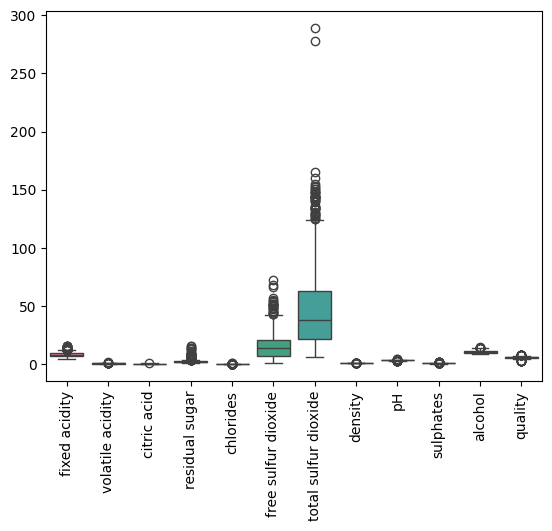

In [7]:
# importamos la librería seaborn para hacer la gráfica
sns.boxplot(data=df)  # graficamos mediante un boxplot usando los datos del DataFrame
plt.xticks(rotation=90)  # giramos las etiquetas del eje X para que se vean mejor
plt.show()  # mostramos la gráfica en pantalla

In [8]:
Q1 = df.quantile(0.25) # calculamos el primer cuartil (Q1) de los datos
Q3 = df.quantile(0.75) # calculamos el tercer cuartil (Q3) de los datos
IQR = Q3 - Q1 # calculamos el rango intercuartílico (IQR) restando Q1 de Q3

# detectamos los outliers comparando los datos con los límites establecidos por el IQR
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
# mostramos la cantidad de outliers detectados por cada columna
print(outliers.sum())


fixed acidity            41
volatile acidity         19
citric acid               1
residual sugar          126
chlorides                87
free sulfur dioxide      26
total sulfur dioxide     45
density                  35
pH                       28
sulphates                55
alcohol                  12
quality                  27
dtype: int64


### 3. Aplicación de PCA:
  * Implementa PCA en el dataset para reducir la dimensionalidad. Determina cuántos componentes principales se necesitan para capturar al menos el 90% de la variabilidad de los datos.
  * Visualiza el gráfico de «explained variance» para mostrar cómo cada componente principal contribuye a la variabilidad total de los datos.

In [9]:
# importamos StandardScaler de la librería sklearn para normalizar los datos
scaler = StandardScaler()
# ajustamos y transformamos los datos del DataFrame, luego los guardamos en un nuevo DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# mostramos las estadísticas descriptivas de los datos escalados
print(df_scaled.describe())

       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.359000e+03      1.359000e+03  1.359000e+03    1.359000e+03   
mean   -6.274108e-16      1.463959e-16  2.091369e-17   -1.202537e-16   
std     1.000368e+00      1.000368e+00  1.000368e+00    1.000368e+00   
min    -2.137008e+00     -2.238023e+00 -1.393258e+00   -1.200903e+00   
25%    -6.972071e-01     -7.623226e-01 -9.328165e-01   -4.611571e-01   
50%    -2.364707e-01     -5.180013e-02 -6.309377e-02   -2.392334e-01   
75%     5.122260e-01      6.040667e-01  8.066290e-01    5.666484e-02   
max     4.370894e+00      5.741690e+00  3.722758e+00    9.599383e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.359000e+03         1.359000e+03          1.359000e+03  1.359000e+03   
mean   1.882232e-16        -8.365477e-17          4.182739e-17  5.286982e-14   
std    1.000368e+00         1.000368e+00          1.000368e+00  1.000368e+00   
min   -1.542254e+00        -1.4

In [10]:
# importamos StandardScaler de la librería sklearn para normalizar los datos
scaler = StandardScaler()
# ajustamos y transformamos los datos del DataFrame, luego los guardamos en un nuevo DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# mostramos las estadísticas descriptivas de los datos escalados
print(df_scaled.describe())

       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.359000e+03      1.359000e+03  1.359000e+03    1.359000e+03   
mean   -6.274108e-16      1.463959e-16  2.091369e-17   -1.202537e-16   
std     1.000368e+00      1.000368e+00  1.000368e+00    1.000368e+00   
min    -2.137008e+00     -2.238023e+00 -1.393258e+00   -1.200903e+00   
25%    -6.972071e-01     -7.623226e-01 -9.328165e-01   -4.611571e-01   
50%    -2.364707e-01     -5.180013e-02 -6.309377e-02   -2.392334e-01   
75%     5.122260e-01      6.040667e-01  8.066290e-01    5.666484e-02   
max     4.370894e+00      5.741690e+00  3.722758e+00    9.599383e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.359000e+03         1.359000e+03          1.359000e+03  1.359000e+03   
mean   1.882232e-16        -8.365477e-17          4.182739e-17  5.286982e-14   
std    1.000368e+00         1.000368e+00          1.000368e+00  1.000368e+00   
min   -1.542254e+00        -1.4

In [11]:
pca = PCA() # importamos PCA de la librería sklearn para realizar reducción de dimensionalidad
# ajustamos el modelo PCA a los datos escalados para calcular la varianza explicada por cada componente
pca.fit(df_scaled)
# obtenemos la proporción de varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
# calculamos la varianza acumulada para determinar cuántos componentes capturan el 90% de la varianza
cumulative_variance = explained_variance.cumsum()
# encontramos el número mínimo de componentes necesarios para alcanzar al menos el 90% de la varianza
components_needed = (cumulative_variance >= 0.90).argmax() + 1
# mostramos el número de componentes necesarios para capturar el 90% de la varianza
print(f"Se necesitan {components_needed} componentes para capturar al menos el 90% de la varianza.")

Se necesitan 8 componentes para capturar al menos el 90% de la varianza.


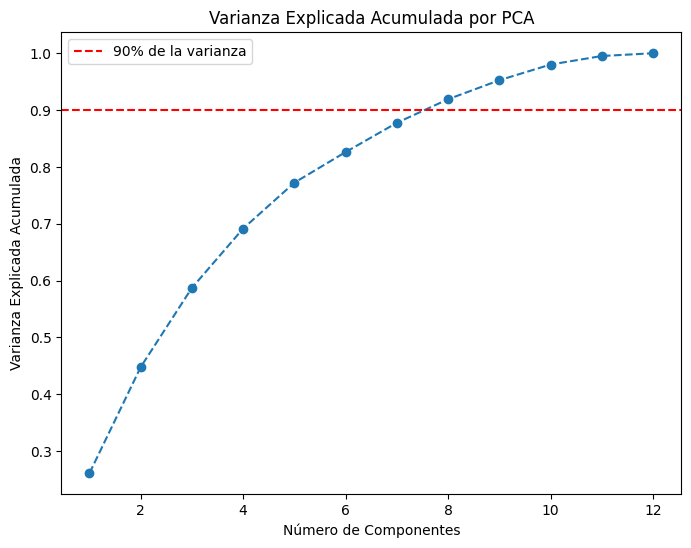

In [12]:
# Graficar la varianza explicada acumulada

plt.figure(figsize=(8, 6)) # creamos una figura de tamaño 8x6 para la gráfica
# graficamos la varianza explicada acumulada en función del número de componentes
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada por PCA') # agregamos un título a la gráfica
plt.xlabel('Número de Componentes') # agregamos una etiqueta al eje X
plt.ylabel('Varianza Explicada Acumulada') # agregamos una etiqueta al eje Y
# dibujamos una línea horizontal en 0.90 para marcar el 90% de la varianza
plt.axhline(0.90, color='r', linestyle='--', label='90% de la varianza')
plt.legend() # agregamos una leyenda para la línea del 90% de la varianza
plt.show() # mostramos la gráfica

In [13]:
# Reducir la dimensionalidad a los componentes necesarios
# configuramos PCA para que utilice el número de componentes necesarios para capturar al menos el 90% de la varianza
pca = PCA(n_components=components_needed)
# aplicamos PCA sobre los datos escalados, reduciendo las dimensiones a los componentes seleccionados
df_pca = pca.fit_transform(df_scaled)
# mostramos las primeras 5 filas del resultado de la transformación PCA
print(df_pca[:5])


[[-1.76660297 -1.18690342 -1.35148375 -0.05331613  0.13922819  1.0003593
  -0.14254236 -0.03544613]
 [-0.94933965 -2.04660494  0.05958776  0.43289603  0.25493347 -0.25302682
   1.43690904  0.29296961]
 [-0.88480511 -1.39158352 -0.66375438  0.31154758  0.12300466 -0.05343251
   0.72013815  0.176824  ]
 [ 2.40560862  0.20533819  0.06490676 -0.86978417 -1.52496323  0.0375124
  -0.21482133  0.14932906]
 [-1.7253385  -1.21103279 -1.10019949 -0.0502518  -0.05017081  1.04292702
  -0.22192763 -0.04505459]]


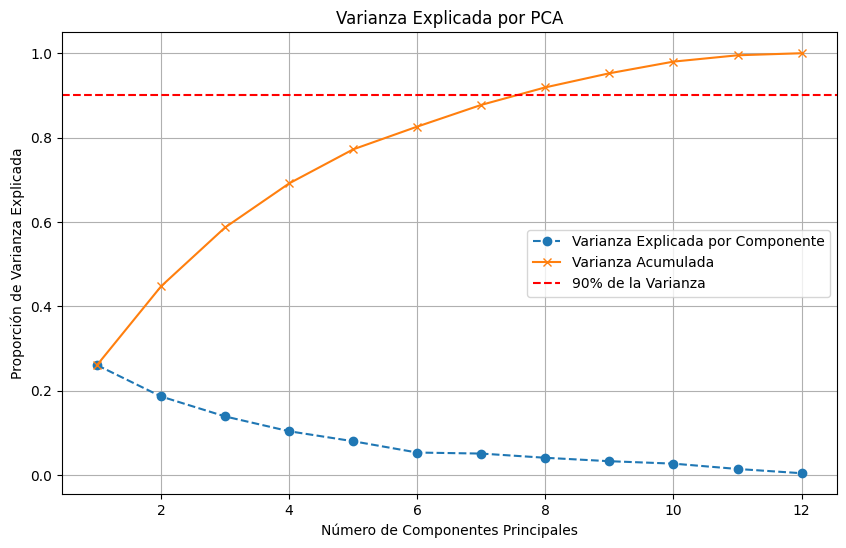

In [14]:
# Aplicar PCA
pca = PCA() # ajustamos el modelo PCA a los datos escalados
pca.fit(df_scaled)
# obtenemos la proporción de varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
# calculamos la varianza acumulada para ver cómo se acumula la varianza explicada por los componentes
cumulative_variance = explained_variance.cumsum()
# creamos una figura de tamaño 10x6 para la gráfica
plt.figure(figsize=(10, 6))
# graficamos la varianza explicada por cada componente
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Varianza Explicada por Componente')
# graficamos la varianza acumulada
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='x', linestyle='-', label='Varianza Acumulada')
# añadimos una línea horizontal en 0.90 para indicar el umbral del 90% de la varianza explicada
plt.axhline(0.90, color='r', linestyle='--', label='90% de la Varianza')
plt.title('Varianza Explicada por PCA') # añadimos un título a la gráfica
# etiquetamos el eje X como el número de componentes principales
plt.xlabel('Número de Componentes Principales')
# etiquetamos el eje Y como la proporción de varianza explicada
plt.ylabel('Proporción de Varianza Explicada')
plt.legend(loc='best') # mostramos la leyenda en la mejor posición
plt.grid(True) # activamos la cuadrícula en la gráfica para facilitar la lectura
plt.show() # mostramos la gráfica


### 4. Interpretación de los componentes principales:
  * Analiza los coeficientes de cada componente principal para identificar qué variables tienen la mayor influencia en cada uno de ellos.
  * Discute cómo la reducción de dimensionalidad mediante PCA puede simplificar la construcción de modelos predictivos al eliminar redundancia en las características.

In [15]:
# Obtener los coeficientes (componentes)
# obtenemos los vectores de los componentes principales (las direcciones de mayor varianza)
components = pca.components_
# creamos un DataFrame con los coeficientes de cada componente principal,
# usando las columnas originales del DataFrame y nombrando las filas como 'Componente 1', 'Componente 2', etc.
coefficients = pd.DataFrame(components, columns=df.columns, index=[f'Componente {i+1}' for i in range(components.shape[0])])
print(coefficients) # mostramos los coeficientes de los componentes principales


               fixed acidity  volatile acidity  citric acid  residual sugar  \
Componente 1        0.484209         -0.264616     0.472147        0.129157   
Componente 2        0.005753         -0.341580     0.143292       -0.136939   
Componente 3       -0.167297         -0.222340     0.099226        0.234943   
Componente 4       -0.238146          0.035549    -0.051884       -0.409398   
Componente 5       -0.084526          0.310151    -0.099255        0.722128   
Componente 6        0.024233         -0.115356    -0.205145       -0.146037   
Componente 7        0.327924          0.690112    -0.178201       -0.262002   
Componente 8       -0.195980         -0.091506    -0.305033        0.172963   
Componente 9       -0.157378         -0.052336    -0.227351        0.235022   
Componente 10      -0.171097          0.161418     0.368672       -0.077353   
Componente 11      -0.247060          0.373721     0.610873        0.094679   
Componente 12       0.641913         -0.003349    -0

Valores grandes (positivos o negativos) indican que la variable tiene una gran influencia en ese componente.
Valores cercanos a cero indican que la variable tiene poca influencia en ese componente.
Si el valor es positivo, la variable contribuye de manera positiva al componente. Si el valor es negativo, la variable tiene una contribución negativa al componente.

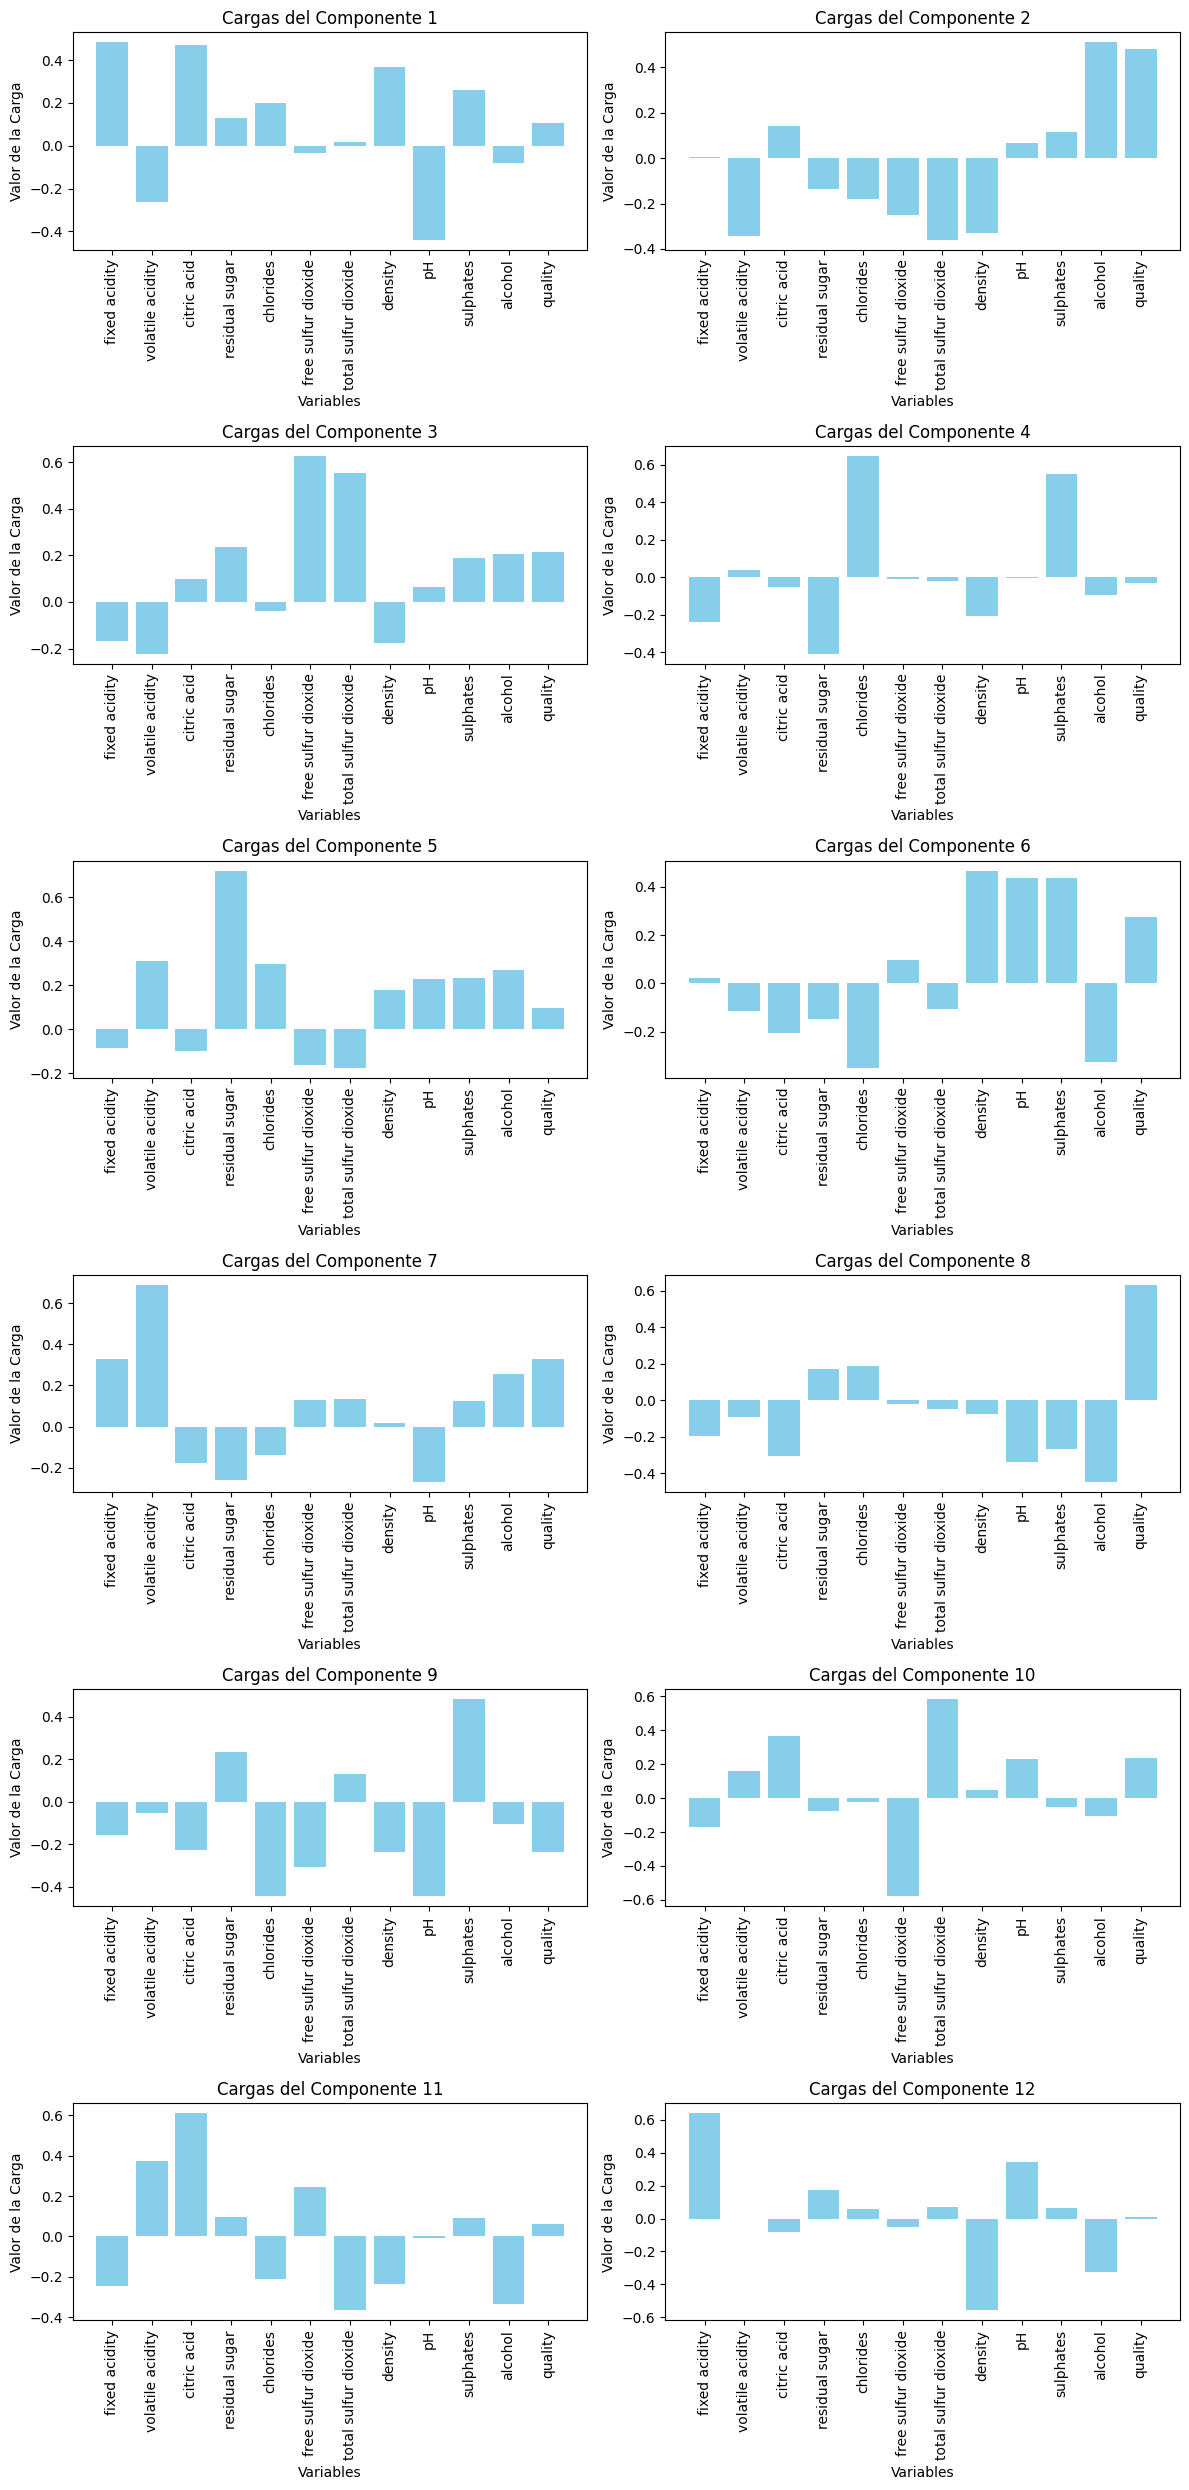

In [16]:
# Graficar las cargas de cada componente
# obtenemos el número de componentes principales calculados
num_components = components.shape[0]
# creamos una figura con subgráficas, distribuidas en filas y columnas,
# donde el número de filas es la mitad de los componentes redondeada hacia arriba
fig, axes = plt.subplots(nrows=np.ceil(num_components / 2).astype(int), ncols=2, figsize=(12, 25))
# aplanamos el array de ejes para que sea más fácil acceder a cada subgráfico
axes = axes.flatten()
# recorremos cada componente para crear una gráfica de barras de sus cargas
for i in range(num_components):
    # creamos una gráfica de barras con las variables en el eje X y los valores de las cargas en el eje Y
    axes[i].bar(coefficients.columns, coefficients.iloc[i], color='skyblue')
    # establecemos el título para cada subgráfico
    axes[i].set_title(f'Cargas del Componente {i+1}')
    # etiquetamos el eje X con el nombre de las variables
    axes[i].set_xlabel('Variables')
    # etiquetamos el eje Y con "Valor de la Carga"
    axes[i].set_ylabel('Valor de la Carga')
    # giramos las etiquetas del eje X para que se vean mejor
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout() # ajustamos el espaciado entre las subgráficas para que no se solapen
plt.show() # mostramos la figura con todas las subgráficas

### 5. Visualización y comparación:
  * Visualiza los datos proyectados en los primeros dos componentes principales utilizando un gráfico de dispersión.
  * Si el dataset tiene etiquetas de clase (como la calidad del vino), observa cómo se distribuyen las clases en el espacio de los componentes principales.

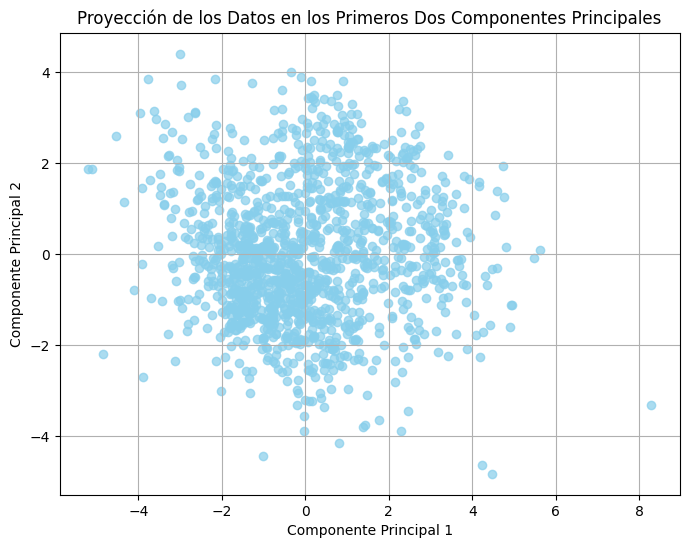

In [17]:
# Aplicar PCA
# aplicamos PCA para reducir los datos a 2 componentes principales
pca = PCA(n_components=2)  # Reducimos a 2 componentes principales
pca_result = pca.fit_transform(df_scaled)  # transformamos los datos escalados en los primeros 2 componentes

plt.figure(figsize=(8, 6)) # creamos una figura de tamaño 8x6 para la gráfica
# creamos un gráfico de dispersión (scatter) con los dos componentes principales en los ejes X y Y
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='skyblue', alpha=0.7)
# añadimos un título a la gráfica
plt.title('Proyección de los Datos en los Primeros Dos Componentes Principales')
plt.xlabel('Componente Principal 1') # etiquetamos el eje X con el nombre del primer componente principal
plt.ylabel('Componente Principal 2') # etiquetamos el eje Y con el nombre del segundo componente principal
plt.grid(True) # activamos la cuadrícula en la gráfica para facilitar la lectura
plt.show() # mostramos la gráfica


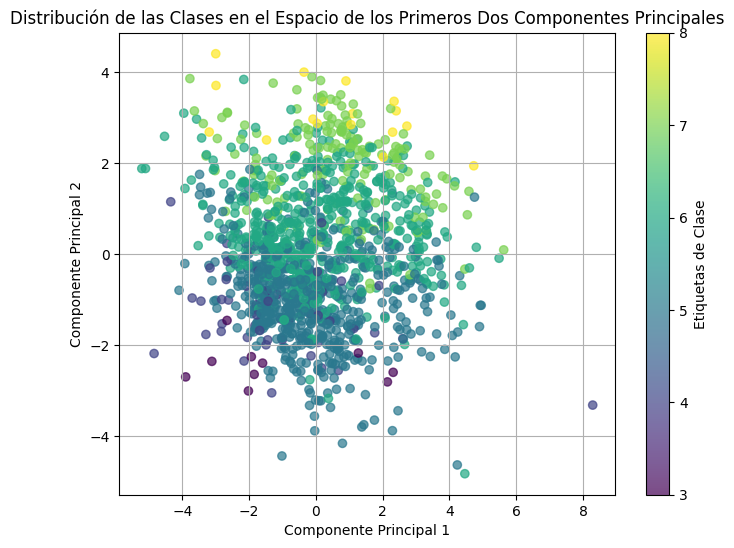

In [18]:
# Estandarizar los datos
scaler = StandardScaler()   # normalizamos los datos usando StandardScaler
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# aplicamos PCA para reducir los datos a 2 componentes principales
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

labels = df['quality'] # obtenemos las etiquetas de las clases (en este caso, 'quality' es la columna de clases)

plt.figure(figsize=(8, 6)) # creamos una figura de tamaño 8x6 para la gráfica
# creamos un gráfico de dispersión (scatter) con los dos componentes principales en los ejes X y Y
# coloreamos los puntos según las etiquetas de clase usando el mapa de colores 'viridis'
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
# añadimos un título a la gráfica
plt.title('Distribución de las Clases en el Espacio de los Primeros Dos Componentes Principales')
plt.xlabel('Componente Principal 1') # etiquetamos el eje X con el nombre del primer componente principal
plt.ylabel('Componente Principal 2') # etiquetamos el eje Y con el nombre del segundo componente principal
# añadimos una barra de colores para mostrar las etiquetas de clase en la gráfica
plt.colorbar(scatter, label='Etiquetas de Clase')
plt.grid(True) # activamos la cuadrícula en la gráfica para facilitar la lectura
plt.show() # mostramos la gráfica
